In [357]:
%matplotlib inline
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime,timedelta

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


In [2]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [50]:
#Fetch only Finance Data
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("tesla")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [56]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbSentimentData = SqlConn.fetchTweetSentimentForModelling("tesla")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [51]:
df_dbFinanceData["date"] = pd.to_datetime(df_dbFinanceData["date"])
df_dbFinanceData.set_index("date", inplace=True)
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume
date,,,,,,,
2010-06-29,tesla,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,tesla,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,tesla,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,tesla,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,tesla,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2022-07-06,tesla,692.340027,703.690002,681.559998,695.200012,695.200012,23951200
2022-07-07,tesla,701.760010,736.090027,696.630005,733.630005,733.630005,27310200
2022-07-08,tesla,727.000000,764.940002,723.479980,752.289978,752.289978,33343700


In [57]:
df_dbSentimentData["date"] = pd.to_datetime(df_dbSentimentData["date"])
df_dbSentimentData.set_index("date",inplace=True)
df_dbSentimentData

,tweetID,financeType,fullText,replyCount,likesCount,retweetCount,sentimentScore,sentiment,adjustedClose,volume
date,,,,,,,,,,
2012-01-11,156927468836630528,tesla,The exec conf room at Tesla used to be called ...,32.0,315,67,0.350000,Positive,5.646000,3361500
2012-01-13,157700726515183616,tesla,"A Tesla Roadster just passed the 100,000 mile ...",5.0,15,51,0.250000,Positive,4.558000,27502000
2012-01-17,159330976378519552,tesla,Will communicate better in the future. Too man...,44.0,163,43,0.150000,Positive,5.320000,23258000
2012-01-17,159396536621596672,tesla,That's not just paranoia (a healthy trait at t...,23.0,16,14,0.175000,Positive,5.320000,23258000
2012-02-10,168022238061268992,tesla,Tesla Model X video,12.0,16,47,0.000000,Neutral,6.220000,9371000
...,...,...,...,...,...,...,...,...,...,...
2022-07-07,1545166492408328192,tesla,Super fired up for future product development ...,NaN,137575,8685,0.333333,Positive,38.790001,13214900
2022-07-07,1545166492408328192,tesla,Super fired up for future product development ...,NaN,137575,8685,0.333333,Positive,733.630005,27310200
2022-07-12,1546666417759653888,tesla,Tesla’s automatic cabin overheat protection sh...,NaN,56429,4023,0.100000,Positive,0.060087,298462083


In [54]:
df_dbFinanceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3030 entries, 2010-06-29 to 2022-07-12
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   financeType    3030 non-null   object 
 1   open           3030 non-null   float64
 2   high           3030 non-null   float64
 3   low            3030 non-null   float64
 4   close          3030 non-null   float64
 5   adjustedClose  3030 non-null   float64
 6   volume         3030 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 189.4+ KB


<AxesSubplot:xlabel='date'>

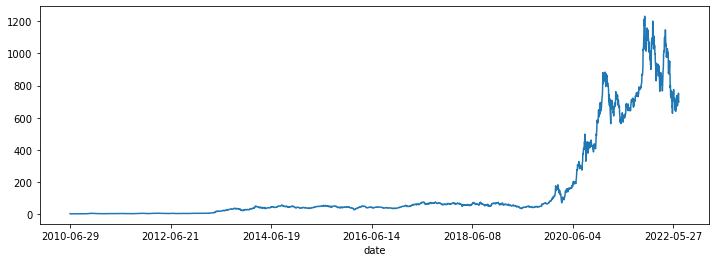

In [13]:
df_dbFinanceData['adjustedClose'].plot(figsize=(12,4))

In [52]:
df_dbFinanceData.index

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06', '2010-07-07', '2010-07-08', '2010-07-09',
               '2010-07-12', '2010-07-13',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='date', length=3030, freq=None)

<AxesSubplot:xlabel='date'>

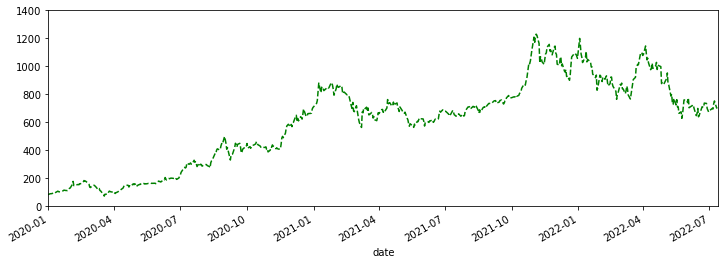

In [53]:
df_dbFinanceData['adjustedClose'].plot(xlim=['2020-01-01','2022-07-13'],ylim=[0,1400],figsize=(12,4),ls='--',c='green')

<AxesSubplot:xlabel='date'>

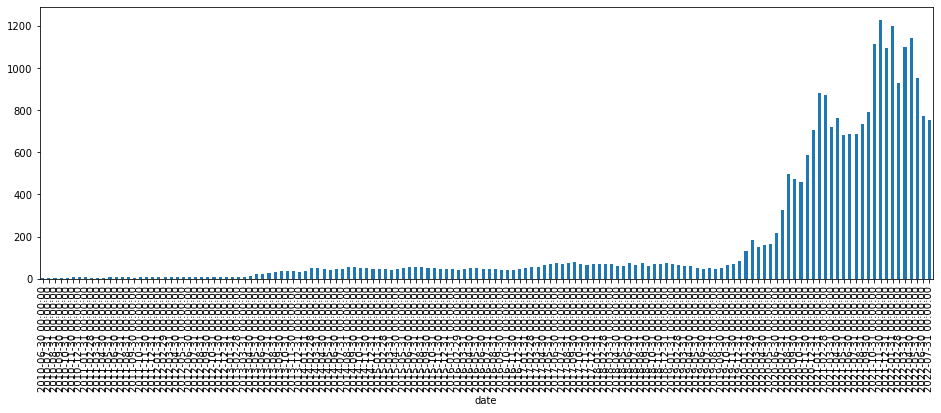

In [63]:
#Resampling to display monthly data
df_resampled = df_dbFinanceData['adjustedClose'].resample(rule='M')
df_resampled.max().plot(kind='bar',figsize=(16,5))

In [71]:
df_filteredData = df_dbFinanceData.loc['2020-01-01':'2022-7-13']
df_filteredData.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08',
               '2022-07-11', '2022-07-12'],
              dtype='datetime64[ns]', name='date', length=636, freq=None)

<AxesSubplot:xlabel='date'>

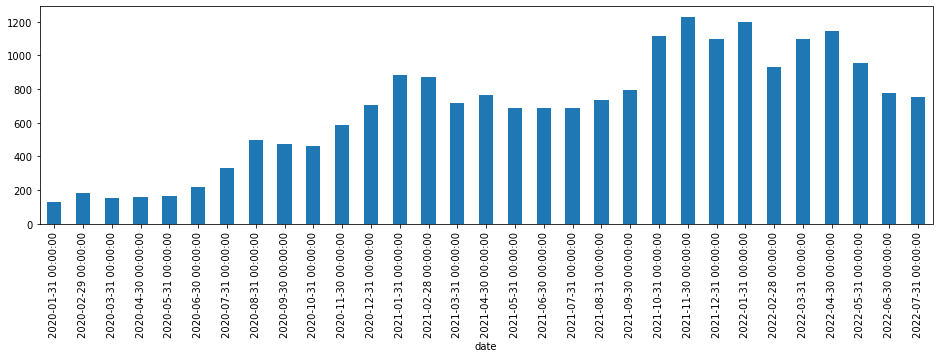

In [73]:
#Nov 2021 was the month when Tesla had highest value - checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData['adjustedClose'].resample(rule='M').max().plot(kind='bar', figsize=(16,4))

<AxesSubplot:xlabel='date'>

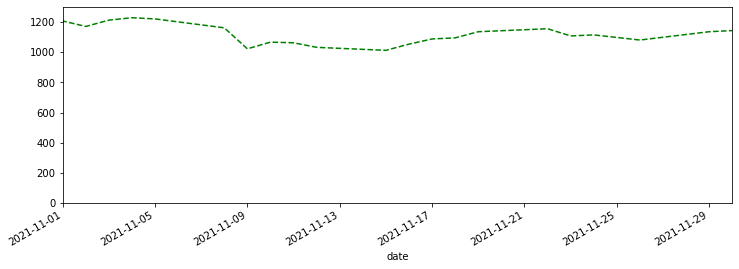

In [78]:
df_filteredData['adjustedClose'].plot(xlim=['2021-11-01','2021-11-30'],ylim=[0,1300],figsize=(12,4),ls='--',c='green')


<AxesSubplot:xlabel='date'>

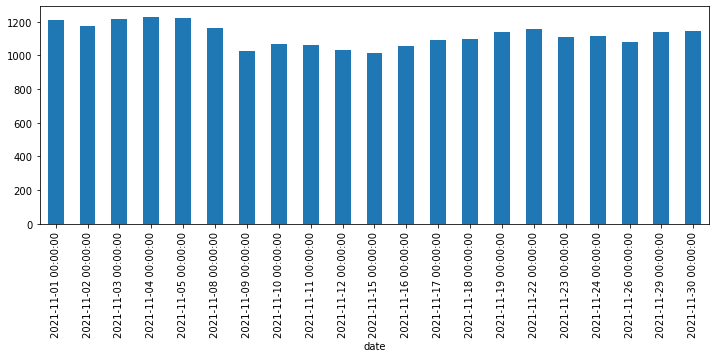

In [84]:
# checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData.loc['2021-11-01':'2021-11-30']['adjustedClose'].plot(kind='bar',figsize=(12,4))

In [363]:
#5 and 15 days rolling mean
df_dbFinanceData["adjustedClose:5 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(5).mean() 
df_dbFinanceData["adjustedClose:15 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(15).mean() 
df_dbFinanceData["adjustedClose:60 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(60).mean() 
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,adjustedClose:15 Days Rolling mean,adjustedClose:5 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff,adjustedClose:45 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,,,,,
2010-06-29,tesla,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,NaN,NaN,4.778000,4.778000,4.778000,NaN,NaN,NaN
2010-06-30,tesla,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,NaN,NaN,4.775600,4.773200,4.769000,-0.012000,NaN,NaN
2010-07-01,tesla,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,NaN,NaN,4.698880,4.620720,4.508000,-0.374000,NaN,NaN
2010-07-02,tesla,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,NaN,NaN,4.527104,4.308432,4.057100,-0.552000,NaN,NaN
2010-07-06,tesla,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,NaN,4.199600,4.266083,3.873859,3.498066,-0.618000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,tesla,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,692.051998,687.015991,694.657106,693.169146,694.535709,-4.000000,731.086443,790.372000
2022-07-07,tesla,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,696.782666,696.647998,702.451686,709.353490,720.598573,38.429993,727.323999,785.507667
2022-07-08,tesla,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,700.335331,712.421997,712.419344,726.528085,741.726176,18.659973,723.835998,781.780333


<AxesSubplot:xlabel='date'>

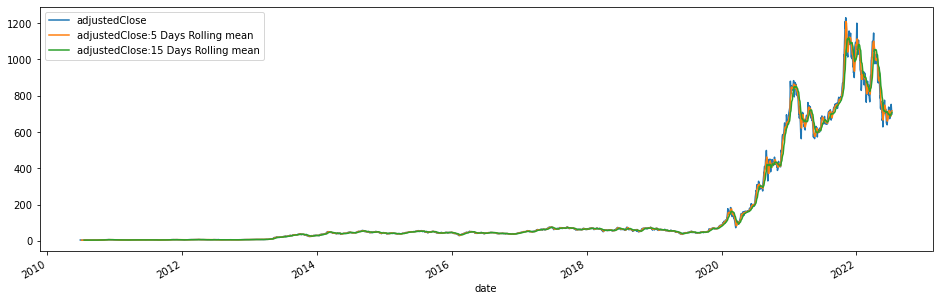

In [364]:
#smoothening the line
df_dbFinanceData[['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean']].plot(figsize=(16,5))

<AxesSubplot:xlabel='date'>

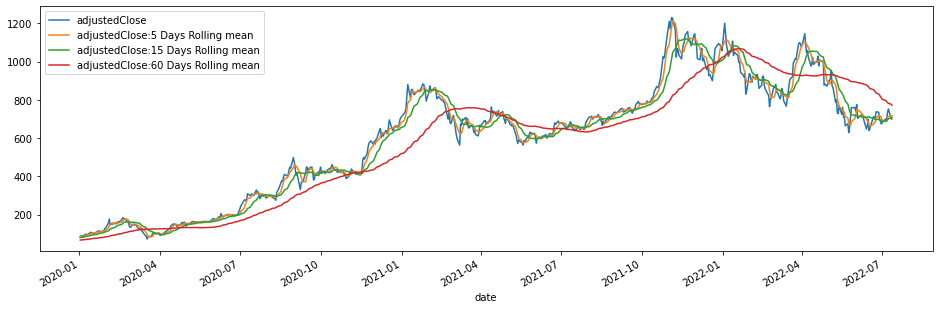

In [366]:
#smoothening the line
df_dbFinanceData.loc['2020-01-01':'2022-7-13'][['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean','adjustedClose:60 Days Rolling mean']].plot(figsize=(16,5))

#rolling mean of 5 days is closer compared to 15 days

<AxesSubplot:xlabel='date'>

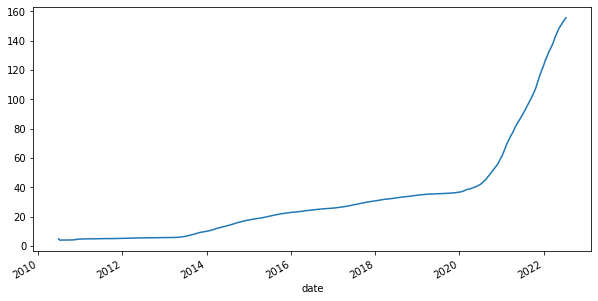

In [367]:
#Cummulative moving average
df_dbFinanceData['adjustedClose'].expanding().mean().plot(figsize=(10,5))

In [368]:
#exponential weighted moving average
df_dbFinanceData['emw0.2']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.2,adjust=False).mean()
df_dbFinanceData['emw0.4']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.4,adjust=False).mean()
df_dbFinanceData['emw_span5']=df_dbFinanceData['adjustedClose'].ewm(span=2,).mean()

<AxesSubplot:xlabel='date'>

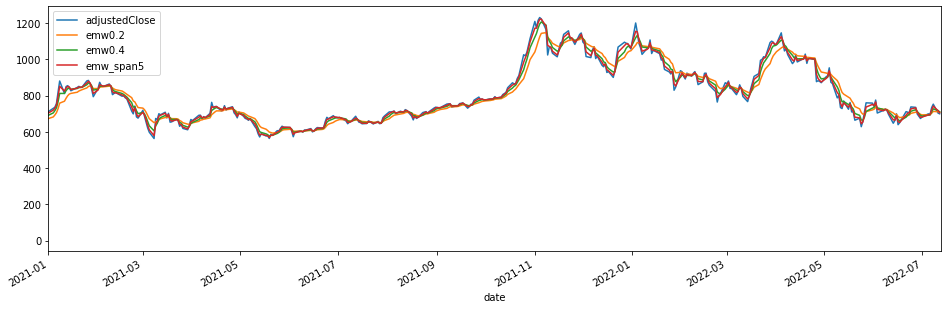

In [369]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-01-01','2022-7-13'],figsize=(16,5))

<AxesSubplot:xlabel='date'>

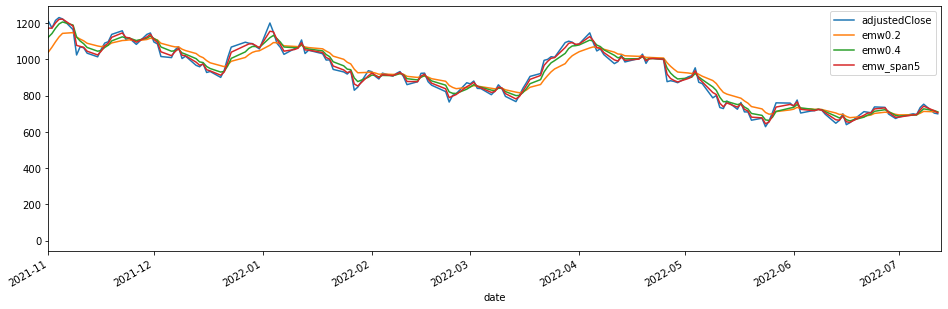

In [370]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-11-01','2022-7-13'],figsize=(16,5))

# Applying ARIMA Model

In [371]:
#Augmented Dickey–Fuller test
def adf_test(series):
    results = adfuller(series)
    print('ADF statistics: {}'.format(results[0]))
    print('P value: {}'.format(results[1]))
    if results[1] < 0.05:
        print("Ho Rejected - data is stationary")
    else:    
        print("Ho Accepted- data is not stationary")

In [372]:
adf_test(df_dbFinanceData['adjustedClose'])

ADF statistics: -0.3586377728879778
P value: 0.9167791107833695
Ho Accepted- data is not stationary


In [373]:
df_dbFinanceData['adjustedClose_first_diff']=df_dbFinanceData['adjustedClose']-df_dbFinanceData['adjustedClose'].shift(1)

In [374]:
adf_test(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#d=1

ADF statistics: -10.966950784001796
P value: 8.058634793412424e-20
Ho Rejected - data is stationary


In [375]:
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,adjustedClose:15 Days Rolling mean,adjustedClose:5 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff,adjustedClose:45 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,,,,,
2010-06-29,tesla,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,NaN,NaN,4.778000,4.778000,4.778000,NaN,NaN,NaN
2010-06-30,tesla,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,NaN,NaN,4.775600,4.773200,4.769000,-0.012000,NaN,NaN
2010-07-01,tesla,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,NaN,NaN,4.698880,4.620720,4.508000,-0.374000,NaN,NaN
2010-07-02,tesla,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,NaN,NaN,4.527104,4.308432,4.057100,-0.552000,NaN,NaN
2010-07-06,tesla,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,NaN,4.199600,4.266083,3.873859,3.498066,-0.618000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,tesla,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,692.051998,687.015991,694.657106,693.169146,694.535709,-4.000000,731.086443,790.372000
2022-07-07,tesla,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,696.782666,696.647998,702.451686,709.353490,720.598573,38.429993,727.323999,785.507667
2022-07-08,tesla,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,700.335331,712.421997,712.419344,726.528085,741.726176,18.659973,723.835998,781.780333


# Calculate AR(p), I(d), MA(q) 

In [376]:
#Estimate ARIMA differencing term,
ndiffs(df_dbFinanceData['adjustedClose'],test='adf')

1

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


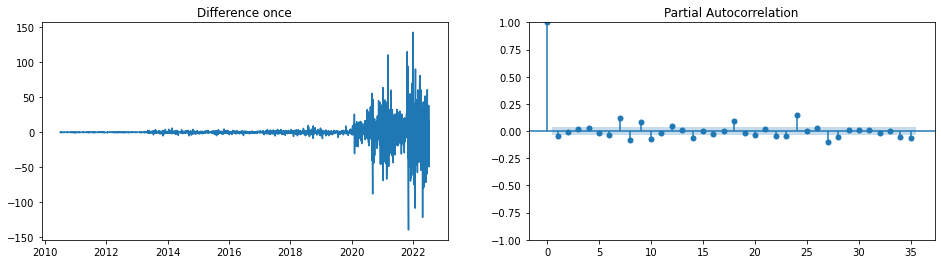

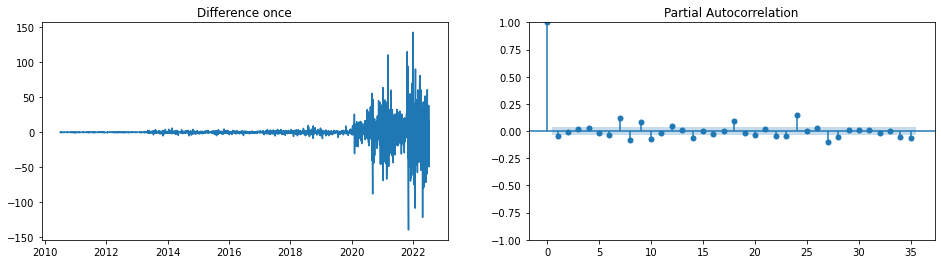

In [377]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)
#p=2

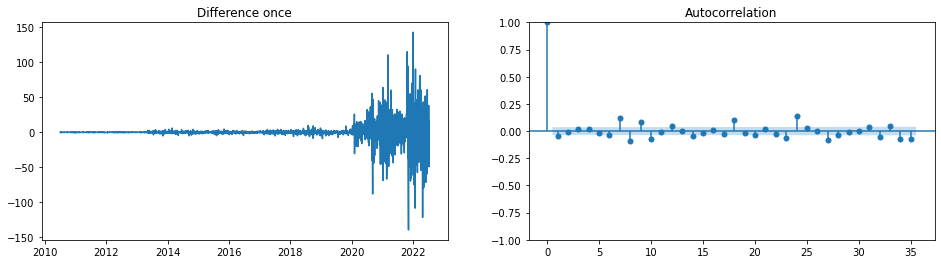

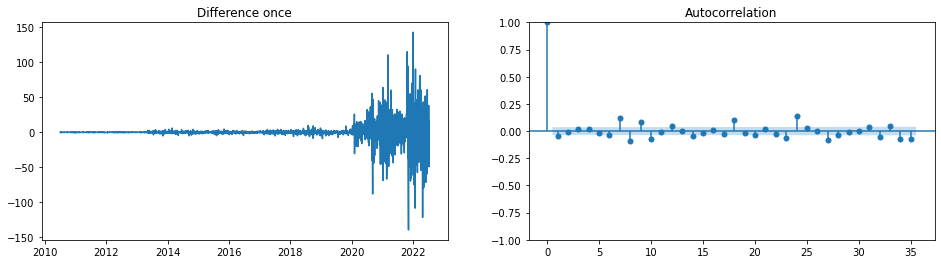

In [115]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)
#q=2

#Other ways to find P and Q

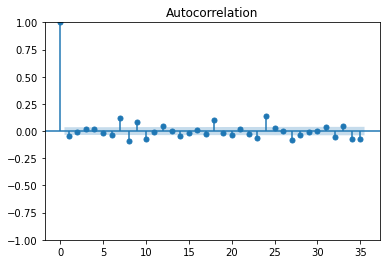

In [117]:
acf = plot_acf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#q=2

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


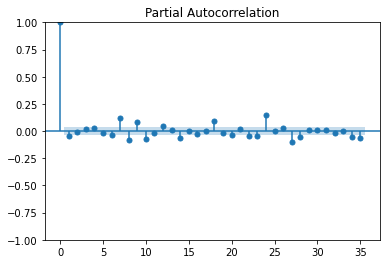

In [118]:
acf = plot_pacf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#p=2

third way to find p,d,q- using Auto_arima

In [119]:
stepwise_fit = auto_arima(df_dbFinanceData['adjustedClose'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23916.803, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23913.452, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23913.378, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23915.816, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23915.337, Time=2.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23915.303, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23902.278, Time=6.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23918.050, Time=5.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23916.311, Time=2.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23901.383, Time=6.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23915.240, Time=1.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23917.977, Time=4.77 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23916.522, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3030
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -11913.057
Date:                Mon, 18 Jul 2022   AIC                          23840.114
Time:                        10:47:07   BIC                          23882.226
Sample:                             0   HQIC                         23855.255
                               - 3030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1588      0.011   -107.115      0.000      -1.180      -1.138
ar.L2         -0.9539      0.014    -69.001      0.000      -0.981      -0.927
ar.L3         -0.0503      0.011     -4.740      0.000      -0.071      -0.029
ar.L4          0.0459      0.007      6.487      0.000       0.032       0.060
ma.L1          1.1329      0.007    151.321      0.000       1.118       1.148
ma.L2          0.9229      0.008    118.057      0.000       0.908       0.938
sigma2       152.6233      1.030    148.153      0.000     150.604     154.642
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            111100.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             892.49   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fitting the Model and Predicting

In [378]:
df_arima = df_dbFinanceData.copy()
df_arima.drop(columns=['financeType'],inplace=True)
train_dataset_end=datetime(2021,7,31)
test_dataset_end=datetime(2022,7,31)

In [379]:
train_data=df_arima[:train_dataset_end]
test_data=df_arima[train_dataset_end+timedelta(days=1):test_dataset_end]

In [380]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [381]:
train_data

,open,high,low,close,adjustedClose,volume,adjustedClose:15 Days Rolling mean,adjustedClose:5 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff,adjustedClose:45 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,NaN,NaN,4.778000,4.778000,4.778000,NaN,NaN,NaN
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,NaN,NaN,4.775600,4.773200,4.769000,-0.012000,NaN,NaN
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,NaN,NaN,4.698880,4.620720,4.508000,-0.374000,NaN,NaN
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,NaN,NaN,4.527104,4.308432,4.057100,-0.552000,NaN,NaN
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,NaN,4.199600,4.266083,3.873859,3.498066,-0.618000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,650.969971,668.200012,647.109985,657.619995,657.619995,25336600,655.246663,653.209998,653.433650,652.344990,653.757041,14.239990,636.554667,633.704168
2021-07-27,663.400024,666.500000,627.239990,644.780029,644.780029,32813300,654.259998,650.066003,651.702925,649.319006,647.772366,-12.839966,637.974668,632.626501
2021-07-28,647.000000,654.969971,639.400024,646.979980,646.979980,16006600,654.415328,648.404004,650.758336,648.383395,647.244109,2.199951,638.875556,631.994501


In [382]:
test_data

,open,high,low,close,adjustedClose,volume,adjustedClose:15 Days Rolling mean,adjustedClose:5 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff,adjustedClose:45 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,,,,
2021-08-02,700.000000,726.940002,698.400024,709.669983,709.669983,33615800,659.665991,673.195996,671.775064,686.385206,699.970512,22.469971,643.754445,633.096834
2021-08-03,719.000000,722.650024,701.010010,709.739990,709.739990,21620300,662.412659,686.187988,679.368049,695.727120,706.483497,0.070007,645.632667,633.719668
2021-08-04,711.000000,724.900024,708.929993,710.919983,710.919983,17002600,666.248657,698.975989,685.678436,701.804265,709.441154,1.179993,647.566444,635.084334
2021-08-05,716.000000,720.950012,711.409973,714.630005,714.630005,12919600,670.517326,706.431995,691.468750,706.934561,712.900388,3.710022,650.000000,636.708168
2021-08-06,711.900024,716.330017,697.630005,699.099976,699.099976,15623000,674.175993,708.811987,692.994995,703.800727,703.700113,-15.530029,652.805777,638.528334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,692.051998,687.015991,694.657106,693.169146,694.535709,-4.000000,731.086443,790.372000
2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,696.782666,696.647998,702.451686,709.353490,720.598573,38.429993,727.323999,785.507667
2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,700.335331,712.421997,712.419344,726.528085,741.726176,18.659973,723.835998,781.780333


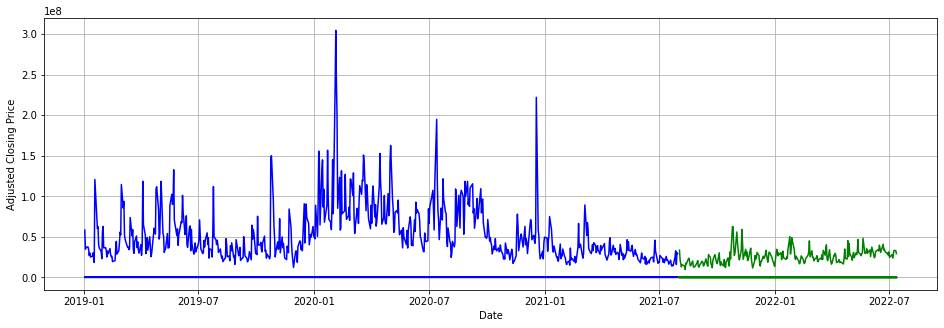

In [152]:
startdate=datetime(2019,1,1)
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.plot(train_data[startdate:],'blue', label="training data")
plt.plot(test_data, 'green' , label="testing data")
#plt.legend(loc="upper left")

# Train the ARIMA Model

In [153]:
model_ARIMA=sm.tsa.arima.ARIMA(train_data['adjustedClose'],order=(2,1,2))

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [154]:
model_ARIMA_fit = model_ARIMA.fit()

In [155]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          adjustedClose   No. Observations:                 2792
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9607.232
Date:                Mon, 18 Jul 2022   AIC                          19224.463
Time:                        11:11:39   BIC                          19254.134
Sample:                             0   HQIC                         19235.175
                               - 2792                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0262      0.008     -3.464      0.001      -0.041      -0.011
ar.L2         -0.9859      0.007   -135.467      0.000      -1.000      -0.972
ma.L1          0.0364      0.008      4.575      0.000       0.021       0.052
ma.L2          0.9853      0.008    125.408      0.000       0.970       1.001
sigma2        57.1878      0.340    168.275      0.000      56.522      57.854
===================================================================================
Ljung-Box (L1) (Q):                  18.58   Jarque-Bera (JB):            215320.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             438.90   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:ylabel='Density'>

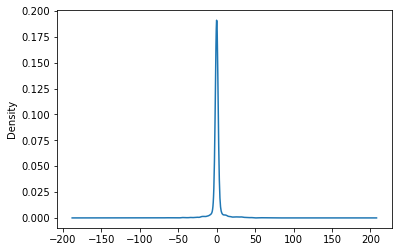

In [157]:
model_ARIMA_fit.resid.plot(kind='kde')

(array([1.80905914e-05, 7.23623657e-05, 2.71358871e-04, 1.08543549e-03,
        4.71440813e-02, 1.35679436e-03, 4.70355377e-04, 7.23623657e-05,
        0.00000000e+00, 1.80905914e-05]),
 array([-89.00571654, -69.20723785, -49.40875915, -29.61028045,
         -9.81180175,   9.98667694,  29.78515564,  49.58363434,
         69.38211303,  89.18059173, 108.97907043]),
 <BarContainer object of 10 artists>)

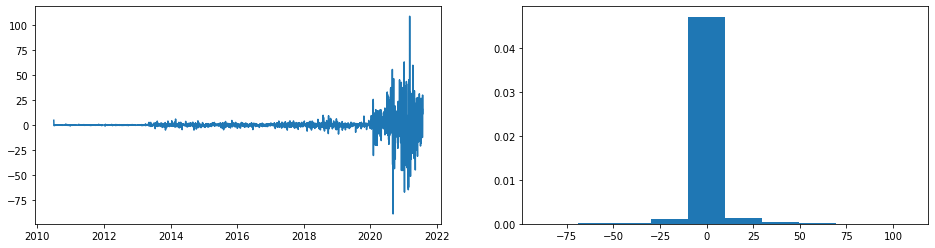

In [156]:
resids = pd.DataFrame(model_ARIMA_fit.resid)
fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,4))
ax1.plot(resids)
ax2.hist(resids, density=True)

In [158]:
##prediction
pred_start_date=pd.to_datetime(test_data.index[0])
pred_end_date=pd.to_datetime(test_data.index[-1])
print(pred_start_date)
print(pred_end_date)

2021-08-02 00:00:00
2022-07-12 00:00:00


In [340]:
-len(train_data)

-2792

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Predicted Adjustclose Values
2792    687.001222
2793    688.535556
2794    688.691282
2795    687.174531
2796    687.060800
           ...    
3025    687.744383
3026    687.692241
3027    687.980743
3028    688.024579
3029    687.739002
Name: predicted_mean, Length: 238, dtype: float64


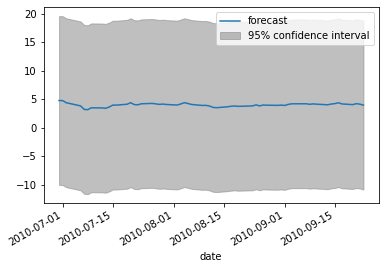

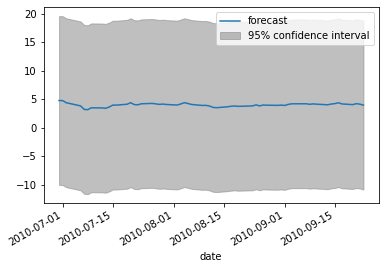

In [341]:
from statsmodels.graphics.tsaplots import plot_predict
adjustedCloseByArima_pred =model_ARIMA_fit.predict(start=len(train_data),end=(len(train_data) + len(test_data)-1)) 
adjustedCloseByArima_predictions = model_ARIMA_fit.get_prediction(start = -len(test_data))
residuals = test_data['adjustedClose']-adjustedCloseByArima_pred
print("Predicted Adjustclose Values")
print(adjustedCloseByArima_pred)
plot_predict(model_ARIMA_fit, start=1, end=60,dynamic=False)

In [342]:
df_yPred = adjustedCloseByArima_predictions.summary_frame(alpha=0.10)

# Extract prediction mean
mean_forecast = adjustedCloseByArima_predictions.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = adjustedCloseByArima_predictions.conf_int()
confidence_intervals


,lower adjustedClose,upper adjustedClose
date,,
2020-08-20,361.075468,390.718977
2020-08-21,385.171735,414.815244
2020-08-24,395.081706,424.725215
2020-08-25,388.310018,417.953527
2020-08-26,389.949815,419.593324
...,...,...
2021-07-26,626.522832,656.166341
2021-07-27,642.412974,672.056483
2021-07-28,631.838551,661.482060


<AxesSubplot:xlabel='date'>

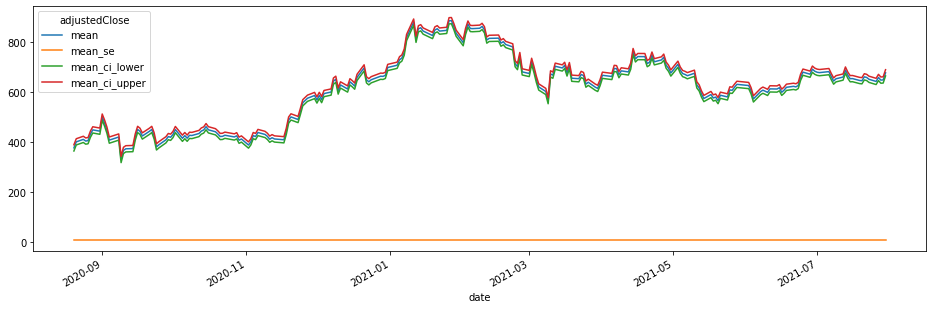

In [343]:
df_yPred.plot(figsize=(16,5))

In [347]:
d1 = pd.DataFrame(test_data['adjustedClose'])
d2 = pd.DataFrame(mean_forecast)
d2['date'] = d1.index
d2.set_index('date',inplace=True)
df_y_yPred = pd.concat([d1,d2],axis=1)

In [348]:
df_y_yPred

,adjustedClose,predicted_mean
date,,
2021-08-02,709.669983,375.897223
2021-08-03,709.739990,399.993489
2021-08-04,710.919983,409.903460
2021-08-05,714.630005,403.131773
2021-08-06,699.099976,404.771569
...,...,...
2022-07-06,695.200012,641.344586
2022-07-07,733.630005,657.234729
2022-07-08,752.289978,646.660305


<AxesSubplot:xlabel='date'>

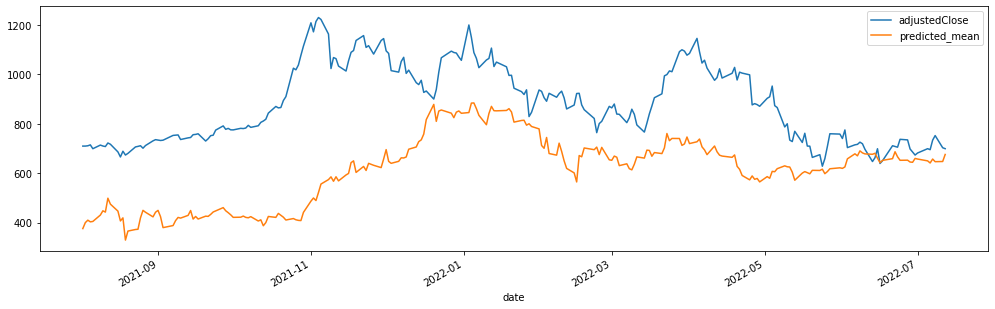

In [349]:
df_y_yPred.plot(figsize=(17,5))

# Forecasting

In [183]:
step = 30
fc = model_ARIMA_fit.forecast(step)
lst_fc = list(fc)
lst_fc

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


[687.0012217725371,
 688.5355563133751,
 688.69128213301,
 687.1745307268177,
 687.0607997927482,
 688.5591145493437,
 688.6319274095617,
 687.1528625108227,
 687.1198847837808,
 688.5789265146632,
 688.5731570447816,
 687.1348723258975,
 687.1782971669053,
 688.5951300401942,
 688.5151444649358,
 687.1204197374735,
 687.2358696497439,
 688.6078679665046,
 688.4580508520139,
 687.109359693284,
 687.2924471324294,
 688.617287366746,
 688.4020252566341,
 687.1015432865491,
 687.3478865762703,
 688.6235387976931,
 688.3472047471746,
 687.0968184904478,
 687.4020568374553,
 688.6267755800076]

In [209]:
fc

2792    687.001222
2793    688.535556
2794    688.691282
2795    687.174531
2796    687.060800
2797    688.559115
2798    688.631927
2799    687.152863
2800    687.119885
2801    688.578927
2802    688.573157
2803    687.134872
2804    687.178297
2805    688.595130
2806    688.515144
2807    687.120420
2808    687.235870
2809    688.607868
2810    688.458051
2811    687.109360
2812    687.292447
2813    688.617287
2814    688.402025
2815    687.101543
2816    687.347887
2817    688.623539
2818    688.347205
2819    687.096818
2820    687.402057
2821    688.626776
Name: predicted_mean, dtype: float64

In [208]:
end_date = pred_end_date 

date_future = end_date + datetime.timedelta(41)

df_future_dates = pd.date_range(start=end_date, end=date_future,freq='B')
df_future_dates

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [258]:
df_future_dates

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [279]:
df_combine = pd.DataFrame(df_future_dates,lst_fc)
df_combine.columns=['date']
df_combine

,date
687.001222,2022-07-12
688.535556,2022-07-13
688.691282,2022-07-14
687.174531,2022-07-15
687.060800,2022-07-18
688.559115,2022-07-19
688.631927,2022-07-20
687.152863,2022-07-21
687.119885,2022-07-22
688.578927,2022-07-25


In [280]:
df_combine = df_combine.reset_index()
df_combine = df_combine.set_index('date')
df_combine

,index
date,
2022-07-12,687.001222
2022-07-13,688.535556
2022-07-14,688.691282
2022-07-15,687.174531
2022-07-18,687.060800
2022-07-19,688.559115
2022-07-20,688.631927
2022-07-21,687.152863
2022-07-22,687.119885


In [281]:
df_combine.rename(columns={"index":"forecasted_mean"},inplace=True)

In [282]:
df_combine

,forecasted_mean
date,
2022-07-12,687.001222
2022-07-13,688.535556
2022-07-14,688.691282
2022-07-15,687.174531
2022-07-18,687.060800
2022-07-19,688.559115
2022-07-20,688.631927
2022-07-21,687.152863
2022-07-22,687.119885


In [291]:
test_data

,open,high,low,close,adjustedClose,volume,adjustedClose:15 Days Rolling mean,adjustedClose:5 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,
2021-08-02,700.000000,726.940002,698.400024,709.669983,709.669983,33615800,659.665991,673.195996,671.775064,686.385206,699.970512,22.469971
2021-08-03,719.000000,722.650024,701.010010,709.739990,709.739990,21620300,662.412659,686.187988,679.368049,695.727120,706.483497,0.070007
2021-08-04,711.000000,724.900024,708.929993,710.919983,710.919983,17002600,666.248657,698.975989,685.678436,701.804265,709.441154,1.179993
2021-08-05,716.000000,720.950012,711.409973,714.630005,714.630005,12919600,670.517326,706.431995,691.468750,706.934561,712.900388,3.710022
2021-08-06,711.900024,716.330017,697.630005,699.099976,699.099976,15623000,674.175993,708.811987,692.994995,703.800727,703.700113,-15.530029
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,692.051998,687.015991,694.657106,693.169146,694.535709,-4.000000
2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,696.782666,696.647998,702.451686,709.353490,720.598573,38.429993
2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,700.335331,712.421997,712.419344,726.528085,741.726176,18.659973


In [355]:
test_data

,open,high,low,close,adjustedClose,volume,adjustedClose:15 Days Rolling mean,adjustedClose:5 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,
2021-08-02,700.000000,726.940002,698.400024,709.669983,709.669983,33615800,659.665991,673.195996,671.775064,686.385206,699.970512,22.469971
2021-08-03,719.000000,722.650024,701.010010,709.739990,709.739990,21620300,662.412659,686.187988,679.368049,695.727120,706.483497,0.070007
2021-08-04,711.000000,724.900024,708.929993,710.919983,710.919983,17002600,666.248657,698.975989,685.678436,701.804265,709.441154,1.179993
2021-08-05,716.000000,720.950012,711.409973,714.630005,714.630005,12919600,670.517326,706.431995,691.468750,706.934561,712.900388,3.710022
2021-08-06,711.900024,716.330017,697.630005,699.099976,699.099976,15623000,674.175993,708.811987,692.994995,703.800727,703.700113,-15.530029
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,692.051998,687.015991,694.657106,693.169146,694.535709,-4.000000
2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,696.782666,696.647998,702.451686,709.353490,720.598573,38.429993
2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,700.335331,712.421997,712.419344,726.528085,741.726176,18.659973


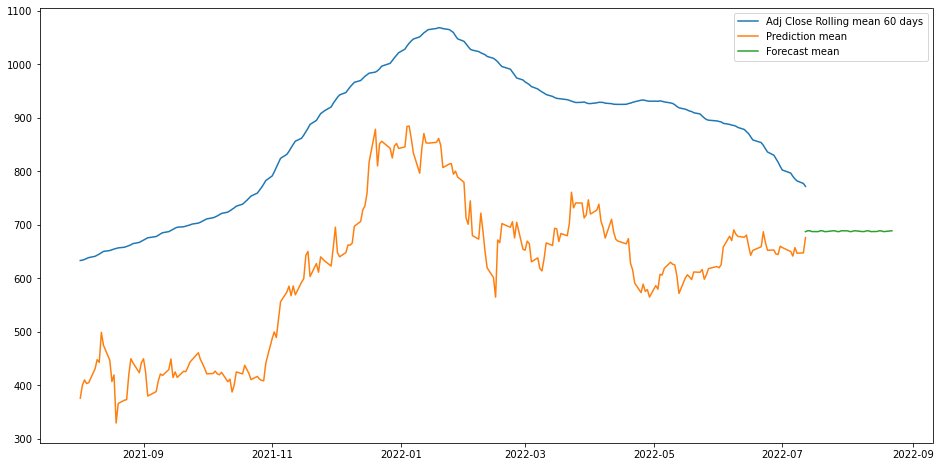

In [384]:
#plot the predictions for validation set
plt.figure(figsize=(16, 8))
plt.plot(test_data["adjustedClose:60 Days Rolling mean"], label='Adj Close Rolling mean 60 days')
#plt.plot(valid, label='Valid')
plt.plot(df_y_yPred["predicted_mean"], label='Prediction mean')
plt.plot(df_combine["forecasted_mean"], label='Forecast mean')
plt.legend()
plt.show()

In [387]:
mape = np.mean(np.abs(np.array(fc[:1])-np.array(test_data_list))/np.abs(test_data_list))
print("MAPE: " + str(mape))
#MEAN ABSOLUTE PERCENTAGE ERROR (MAPE) = 19.9% mean this model as performed Good

MAPE: 0.199782235577032
